# Classfication_Activation_Map可视化


* 使用方法：
    0. 将本文件和utils.py放在slim根目录
    1. 加载自己的dataset
        ```python
        from datasets import card_classfication
        dst = card_classfication
        dst_dir = './cards_for_train/'
        dataset = dst.get_split('validation', dst_dir)# 默认验证集
        ```
    2. 修改参数kw
       其中参数是：
       
        ---
        ```python
        graph_path: 计算图的的path，.meta文件
        weight_path: 参数的path,.ckpt
        input_name: 计算图入口
        dataset: 使用的数据集，slim框架下的
        weight_name:GAP层后直接用于分类的weight的name
        last_conv_layers：最后一个卷积层得到的tensor的name,其实是输入GAP层的tensor
        logit: logit tensor的name
        plot_dir: 保存图片的地址,图片将保存到"plot_dir/CAM_OUT/iter_t/" 文件夹下
        _iters:循环次数
        ```
        ---
    3. 运行函数`show_conv_out(**kw)`
* exp
    ---
    
    ```python
    from datasets import card_classfication
    dst = card_classfication
    dst_dir = './cards_for_train/'
    dataset = dst.get_split('validation', dst_dir)# 默认验证集

    kw1 = {
        'graph_path':'MOBILE_NET_V2_CAM/model.ckpt-46542.meta',
        'weight_path':'MOBILE_NET_V2_CAM/model.ckpt-46542',
        'input_name':'fifo_queue_Dequeue',
        'dataset':dataset,
        'weight_name':'MobilenetV2/Logits/Conv2d_1c_1x1/weights:0',
        'last_conv_layers':'MobilenetV2/embedding:0',
        'logit':'MobilenetV2/Predictions/Reshape:0',
        'plot_dir':'out',
        'batch_size':64,
        '_iters':1,
    }
    show_cam_out(**kw1)
    ```
    ---
    
    
* 需要注意的点:
    1. 依赖的py文件：utils.py, 用于prepare_dir
    2. 计算图中的变量定义不同需要在计算图中找到对应的变量名修改
    3. 因为计算meta文件定义了计算图,在这里需要使用和它相同的batch_size才能使用
    4. 未完成的点:在原本的计算图中得到的logit是有bias的,需要对last_conv层进行补偿才能得到与计算logit相同的 featuremap,所以这里在数学上有部分不合理.但考虑到这样已经能够达到很好的效果了,我并未如此严谨.
    5. last_conv参数需要的是输入GAP(global_average_pooling)层的tensor
    6. 创建dataset的时候使用的是clf的20000图250类的包, 使用slim创建tfrecord文件
    7. 我训练好的0.85acc的模型一并上传
    

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import utils # 用于prepare dir
from IPython import display
from preprocessing import inception_preprocessing
from datasets import dataset_utils
import cv2
# Main slim library
from tensorflow.contrib import slim

In [10]:
def load_batch(dataset, batch_size=64, height=224, width=224, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # 注意这里使用的是inception的预处理方案,得到的图片是白化后的array,[-1,1]
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, _, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, labels

def plot_cam_output(img,feature_map_before_GAP,aim_class_weight, name, plot_dir):
    """
    输出_CAM 图并保存到plot_dir
    img: 输入网络的图片, 注意在preprocessing后得到的是[-1,1], shape:width*height*3
    feature_map_before_GAP: numpy array shape: a*a*channels
    aim_class_weight: 某个class的weight,一个1d的array shape: channels
    name: string, 保存的名字,pic名字+class名字会比较好
    plot_dir: 保存的地址
    :return: nothing, plots are saved on the disk
    """
    print(name)
    
    #文件地址
    plot_dir = os.path.join(plot_dir, name)+'.jpg'
    
    heatmap = feature_map_before_GAP.dot(aim_class_weight)
    #heatmap -= np.min(heatmap)# 原文是直接设置为0 这里稍有不同,可以尝试减去最小值后归一化
    heatmap = np.maximum(heatmap,0) 
    heatmap /= np.max(heatmap)
    # plt.matshow(heatmap)#输出heat map 低像素
    
    #将heatmap暴力展开成原图大小后转化成一个热力图,使用opencv
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0])) 
    heatmap = np.uint8(255*heatmap) 
    heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
    
    #img 也是实数 -1~1,先归一化到[0~1],然后转化成0~225,并且opencv的图片颜色通道不同,将本来的RGB翻转为GBR
    img -= np.min(img)
    img /= np.max(img)
    img = np.uint8(255*img)[:,:,::-1]
    
    #把 heatmap加到原图上, 0.4为经验值, 并保存图片
    superimposed_img = heatmap*0.4+img
    cv2.imwrite(plot_dir,superimposed_img)
    
    # 显示图片
    plt.imshow(superimposed_img[:,:,::-1]/np.max(superimposed_img)) 
    plt.show()


def show_cam_out(graph_path,
                 weight_path,
                  input_name,
                  dataset,
                  weight_name,
                  last_conv_layers,
                  logit,
                  plot_dir = 'out2',
                 batch_size = 64,
                 _iters =10,
                show_original = False):
    '''    
    graph_path: 计算图的的path，.meta文件
    weight_path: 参数的path,.ckpt
    input_name: 计算图入口的名字
    dataset: 使用的数据集，slim框架下的
    weight_name:weight的name tf.get_default_graph().get_tensor_by_name
    last_conv_layers：可视化的层名
    logit:logit的tensor名
    plot_dir: 保存图片的地址
    _iters:循环次数
    show_orginal: 是否显示原图
    
    exp:
    from datasets import card_classfication
    dst = card_classfication
    dst_dir = './cards_for_train/'
    dataset = dst.get_split('validation', dst_dir)# 默认验证集

    kw1 = {
        'graph_path':'MOBILE_NET_V2_CAM/model.ckpt-46542.meta',
        'weight_path':'MOBILE_NET_V2_CAM/model.ckpt-46542',
        'input_name':'fifo_queue_Dequeue',
        'dataset':dataset,
        'weight_name':'MobilenetV2/Logits/Conv2d_1c_1x1/weights:0',
        'last_conv_layers':'MobilenetV2/embedding:0',
        'logit':'MobilenetV2/Predictions/Reshape:0',
        'plot_dir':'out',
        'batch_size':64,
        '_iters':1,
    }
    show_cam_out(**kw1)
    '''
    
    plot_dir = os.path.join(plot_dir,'CAM_OUT')
    init = tf.global_variables_initializer()
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        sess.run(init)
        
        #加载计算图
        saver = tf.train.import_meta_graph(graph_path)
        
        #加载变量
        saver.restore(sess, weight_path)
        
        #获取需要的tensor
        graph = tf.get_default_graph()
        inputs = graph.get_operation_by_name(input_name).outputs[0]
        conv_tensor = graph.get_tensor_by_name(last_conv_layers)
        logit = graph.get_tensor_by_name(logit)
        _weight =  tf.get_default_graph().get_tensor_by_name(weight_name)
        
        #获得图片和labels
        images,labels = load_batch(dataset,batch_size=batch_size)
        
        #计算得到weight的值,一个array,并reshape到 (channels,classes)
        weight = sess.run(_weight)
        weight = np.squeeze(weight)
        
        with slim.queues.QueueRunners(sess):
            for iter_t in range(_iters):
                # 创建或清空dir,本次迭代的到的文件保存到 "plot_dir/CAM_OUT/iter_t/"
                utils.prepare_dir(os.path.join(plot_dir,str(iter_t)), empty=True)
                
                # 计算的到图像和labels
                np_image, np_label = sess.run([images, labels])
                feed_dict = {inputs: np_image}

                
                print('IN_CAM')
                
                # 计算在GAP层前的feature map, shape为(batch_size,a,a,channels)
                # 和logit, 用于分类
                conv_out,logit_out = sess.run([conv_tensor,logit],feed_dict=feed_dict) #64, 7, 7, 1280
                
#                 # 计算在GAP层前的feature map, shape为(batch_size,a,a,channels)
#                 logit_out = sess.run(logit,feed_dict=feed_dict) #64, 250

                # 获得f1 预测值
                predict = np.argmax(logit_out,axis=-1)
                
                # 对batch中每一张图片进行可视化
                for i in range(batch_size):
                    # 去白化
                    img_i = np_image[i]-np.min(np_image[i])
                    img_i /= np.max(img_i)
                    
                    # 真实和预测
                    real_name = dataset.labels_to_names[np_label[i]]
                    predict_name = dataset.labels_to_names[predict[i]]
                    # 输出原图和真实分类,预测分类(title), 不需要输出原图了
                    if show_original:
                        plt.figure()
                        plt.imshow(img_i)
                        height, width, _ = np_image[i].shape
                        plt.title('%s %s, %d x %d' % (real_name,predict_name, height, width))
                        plt.axis('off')
                        plt.show()
                    
                    # 先输出对真实label的activation area
                    plot_cam_output(np_image[i],conv_out[i],weight[:,np_label[i]],str(i)+'_'+real_name,plot_dir=os.path.join(plot_dir,str(iter_t)))
                    if real_name != predict_name:# 分类错误则输出预测label的activation area
                        print('not right')
                        plot_cam_output(np_image[i],conv_out[i],weight[:,predict[i]],str(i)+'_wrong_'+predict_name,plot_dir=os.path.join(plot_dir,str(iter_t)))
                    

                

In [11]:
from datasets import card_classfication
dst = card_classfication
dst_dir = './cards_for_train/'
dataset = dst.get_split('validation', dst_dir)# 默认验证集

kw1 = {
    'graph_path':'MOBILE_NET_V2_CAM/model.ckpt-46542.meta',
    'weight_path':'MOBILE_NET_V2_CAM/model.ckpt-46542',
    'input_name':'fifo_queue_Dequeue',
    'dataset':dataset,
    'weight_name':'MobilenetV2/Logits/Conv2d_1c_1x1/weights:0',
    'last_conv_layers':'MobilenetV2/embedding:0',
    'logit':'MobilenetV2/Predictions/Reshape:0',
    'plot_dir':'out',
    'batch_size':64,
    '_iters':1,
}

INFO:tensorflow:Restoring parameters from MOBILE_NET_V2_CAM/model.ckpt-46542
IN_CAM
0_sink_square


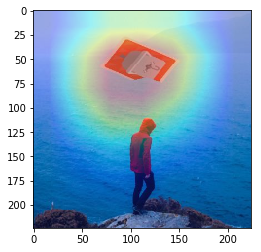

1_can_square


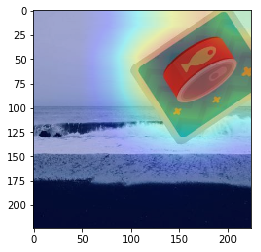

2_police_square


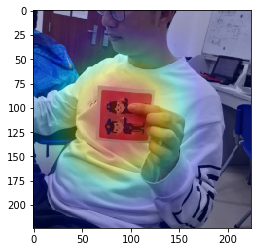

3_sled_square


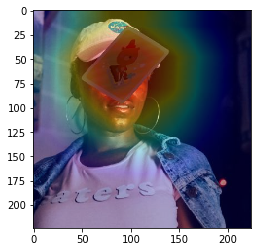

4_lady_square


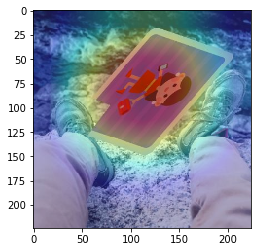

5_washing-machine_square


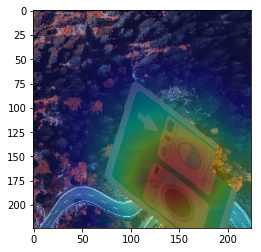

not right
5_wrong_dryer_square


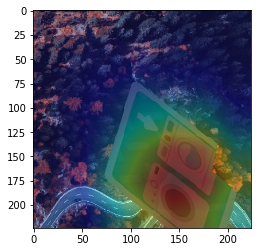

6_sprinkler_square


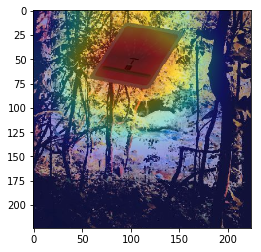

7_babysister_square


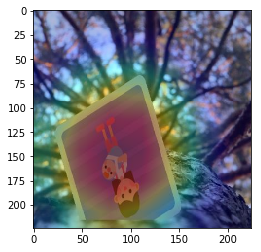

8_tea_square


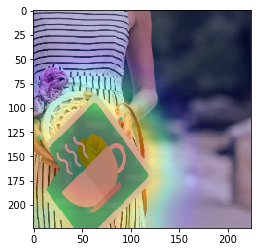

9_airplane_square


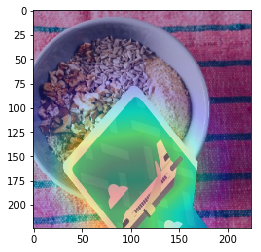

10_mom_square


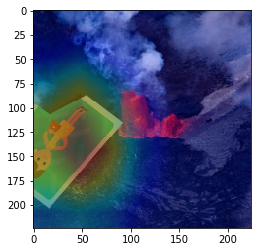

not right
10_wrong_mother_square


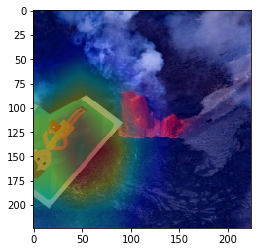

11_mom_square


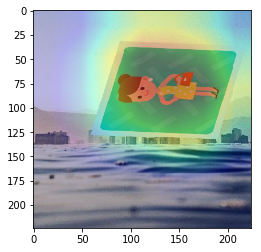

not right
11_wrong_mother_square


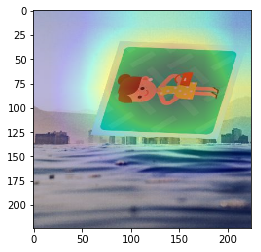

12_mommy_square


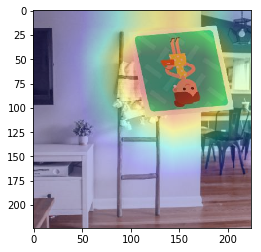

13_mother_square


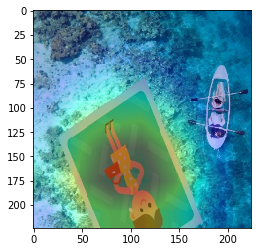

14_count_square


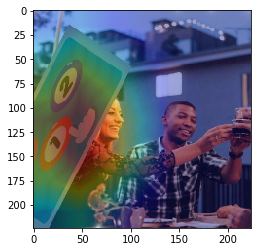

15_monkey_square


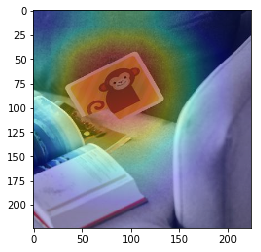

not right
15_wrong_mouse_square


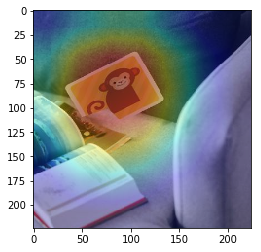

16_cat_square


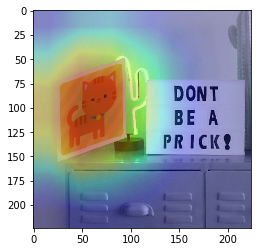

17_noodle_square


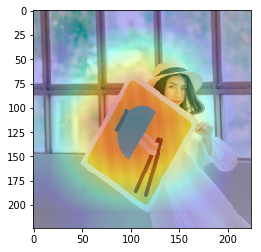

18_pizza_square


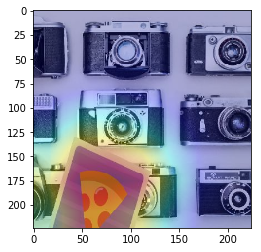

19_two_square


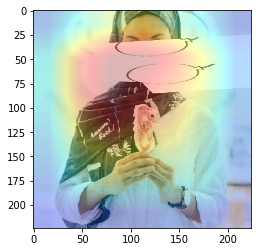

20_food_square


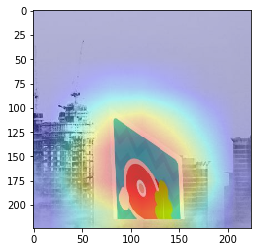

21_careful_square


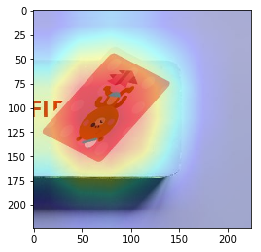

22_father_square


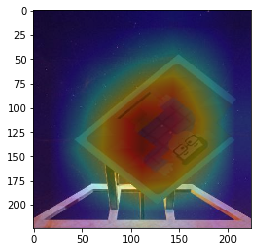

not right
22_wrong_daddy_square


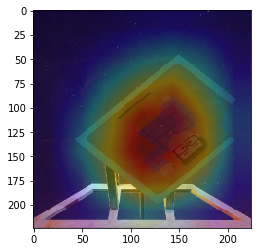

23_mom_square


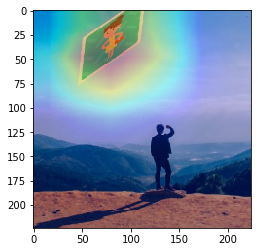

not right
23_wrong_mommy_square


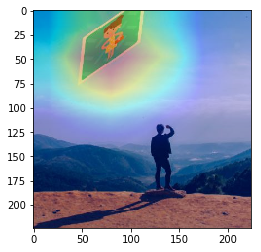

24_hose_square


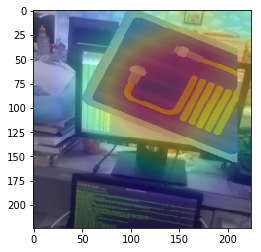

25_sauce_square


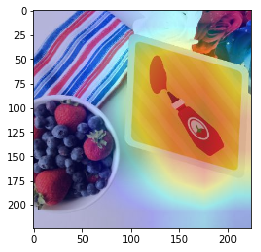

26_sunscreen_square


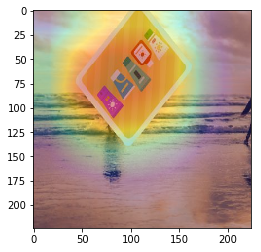

27_soft_square


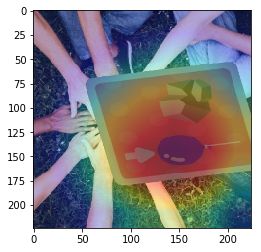

28_butterfly_square


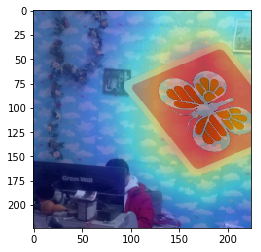

29_Grandma_square


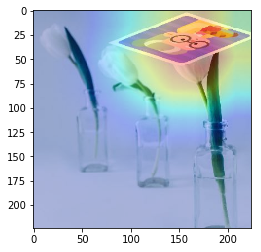

30_lawn-mower_square


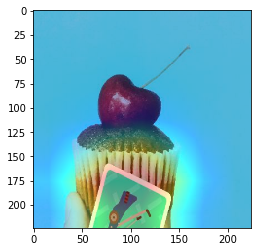

31_bring_square


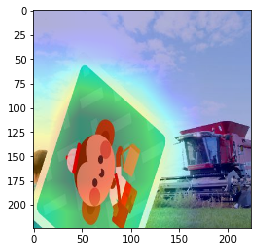

32_lunch_square


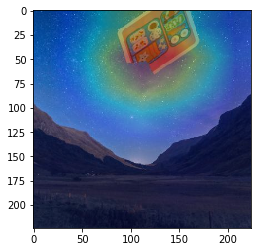

not right
32_wrong_work_square


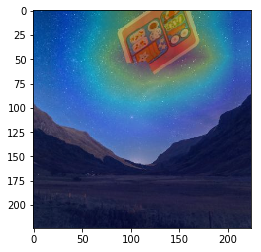

33_home_square


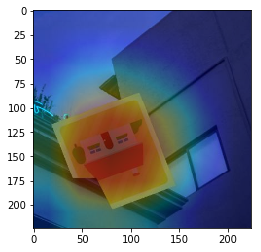

34_purse_square


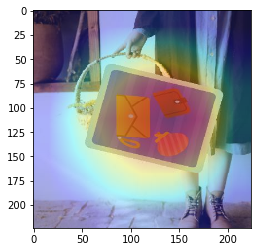

35_mom_square


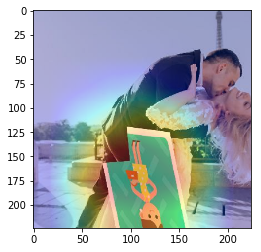

not right
35_wrong_mother_square


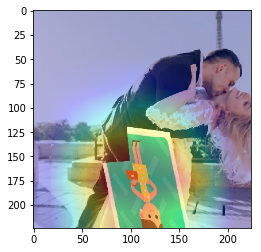

36_lady_square


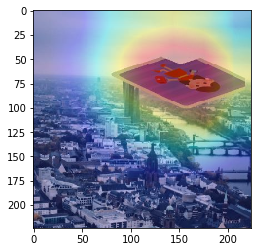

not right
36_wrong_cut_square


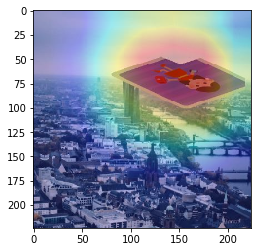

37_mom_square


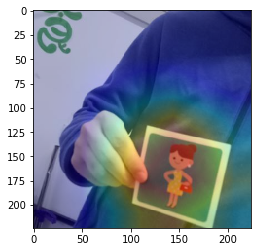

not right
37_wrong_dinner_square


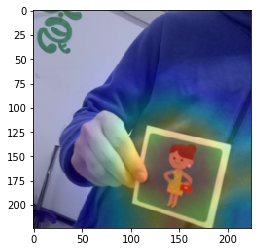

38_moon_square


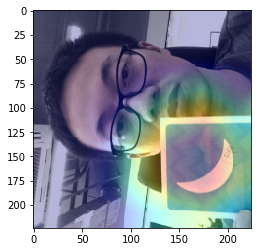

39_tissue_square


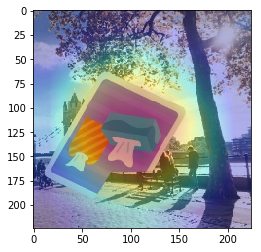

40_sink_square


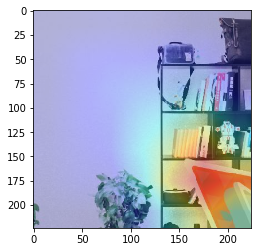

not right
40_wrong_dog_square


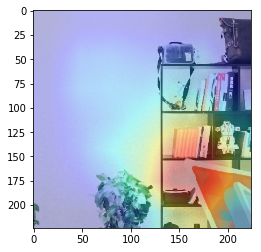

41_bee_square


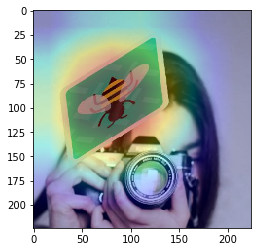

42_rabbit_square


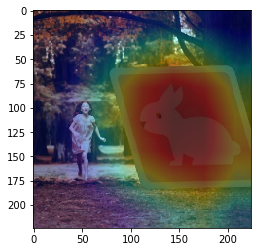

43_tiger_square


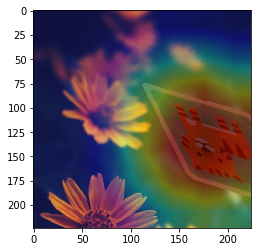

44_moose_square


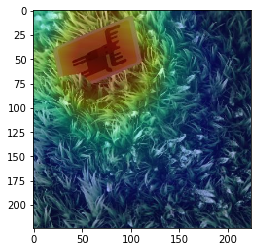

45_washing-machine_square


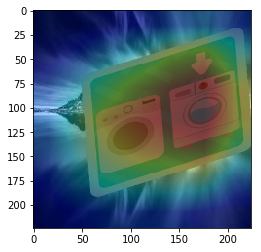

not right
45_wrong_dryer_square


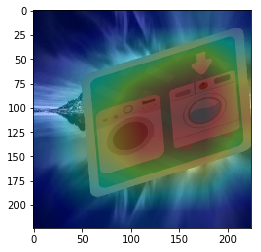

46_tree_square


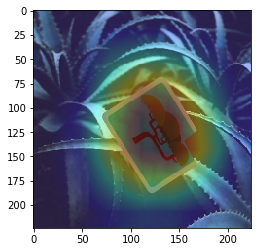

47_beef_square


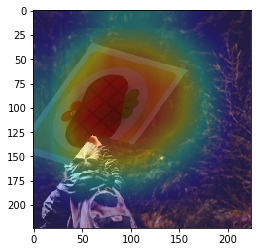

48_listen_square


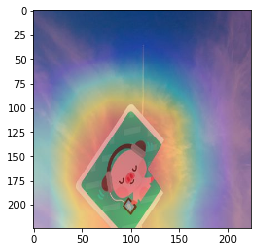

49_belt_square


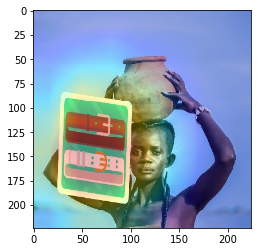

50_accessory_square


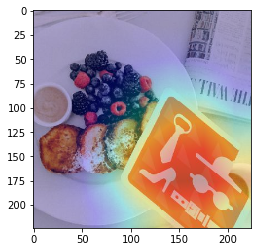

51_chicken_square


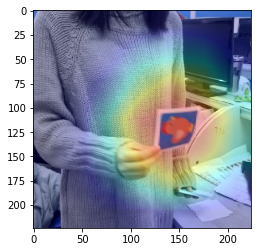

52_sticky_square


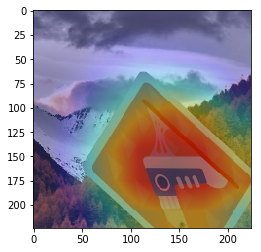

53_Vocab_pee_square


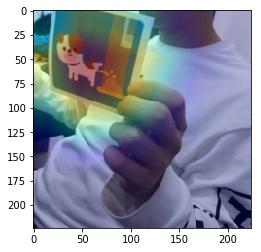

54_ten_square


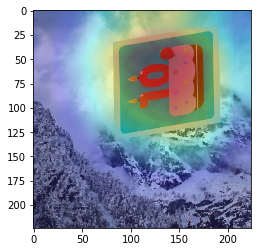

55_beads_square


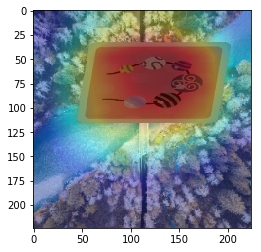

56_present_square


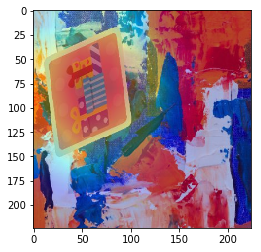

57_Dad_square


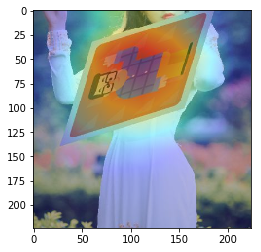

not right
57_wrong_father_square


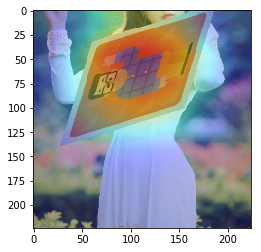

58_nap_square


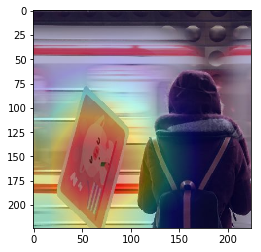

not right
58_wrong_kitty_square


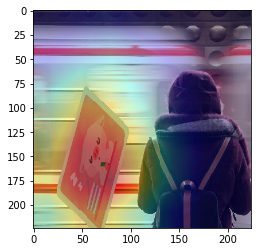

59_nine_square


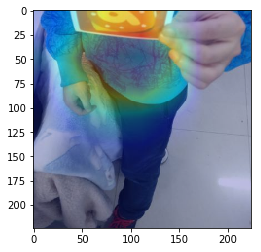

not right
59_wrong_two_square


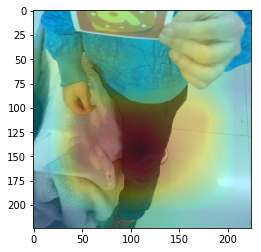

60_grass_square


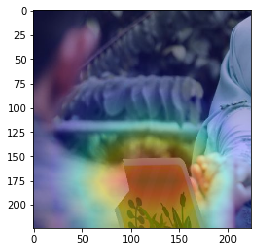

61_noodle_square


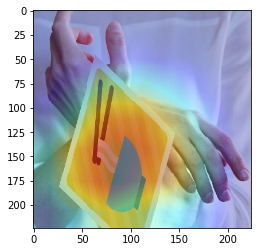

62_same_square


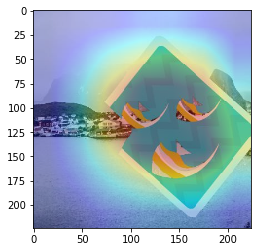

63_kite_square


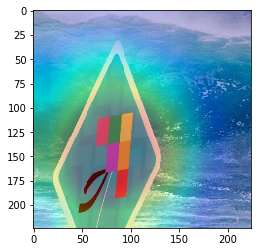

In [12]:
show_cam_out(**kw1)